Практическое задание:
- взять любой набор данных для бинарной классификации
- сделать обзорный анализ выбранного датасета
- сделать feature engineering
- обучить любой классификатор (какой вам нравится)
- разобраться с SHAP и построить важности признаков для:
- всего тестового набора данных (summary_plot - дать интерпретацию)
- для топ 10%
- для отдельных наблюдений вывести force_plot и попытаться проинтерпретировать результат

In [1]:
import pandas as pd

from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import r2_score

import shap
# load JS visualization code to notebook
shap.initjs()

In [2]:
#соберем наш простой pipeline, но нам понадобится написать класс для выбора нужного поля
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]

In [3]:
cancer = load_breast_cancer()
df = pd.DataFrame(data=cancer['data'], columns=cancer['feature_names'])
y = cancer.target
df.head(3)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758


Проверим датасет на наличие пропусков и необходимости приведения типов:

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            569 non-null    float64
 12  perimeter error          569 non-null    float64
 13  area error               569 non-null    float64
 14  smoothness error         5

In [5]:
final_transformers = list()
    
for column in cancer.feature_names:
    transformer = Pipeline([
                ('selector', NumberSelector(key=column)),
                ('scaler', StandardScaler())
            ])
    final_transformers.append((column, transformer))

In [6]:
model = Pipeline([('feats', FeatureUnion(final_transformers)),
                 ('classifier', RandomForestClassifier())])

In [7]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df, y, random_state=0)

#обучим пайплайн
model.fit(X_train, y_train)

Pipeline(steps=[('feats',
                 FeatureUnion(transformer_list=[('mean radius',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='mean radius')),
                                                                 ('scaler',
                                                                  StandardScaler())])),
                                                ('mean texture',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='mean texture')),
                                                                 ('scaler',
                                                                  StandardScaler())])),
                                                ('mean perimeter',
                                                 Pipeline(steps=[('selector',
           

Посчитаем коэффициент детерминации (R2) и feature_importance:

In [8]:
predictions =  model.predict(X_test)
 
r2_score(y_pred=predictions, y_true=y_test)

0.850104821802935

In [9]:
importances = model[1].feature_importances_
importances

array([0.03236909, 0.01612495, 0.06565182, 0.05394607, 0.00606374,
       0.00577151, 0.03736381, 0.12529363, 0.00747113, 0.00294656,
       0.01937283, 0.00549904, 0.01079009, 0.01751018, 0.00463684,
       0.00462657, 0.00791505, 0.00921319, 0.0045839 , 0.00512603,
       0.08817776, 0.016084  , 0.08600568, 0.12623786, 0.0143757 ,
       0.02119061, 0.02360889, 0.15978854, 0.01335251, 0.0089024 ])

In [10]:
model_features = pd.DataFrame(model[1].feature_importances_, 
                        cancer.feature_names, 
                        columns=['coefficient'])

model_features.sort_values(by=['coefficient'], ascending=False)

,coefficient
worst concave points,0.159789
worst area,0.126238
mean concave points,0.125294
worst radius,0.088178
worst perimeter,0.086006
mean perimeter,0.065652
mean area,0.053946
mean concavity,0.037364
mean radius,0.032369
worst concavity,0.023609


#### Объясним предсказания модели, используя SHAP

In [11]:
explainer = shap.TreeExplainer(model[1])
shap_values = explainer.shap_values(X_test)

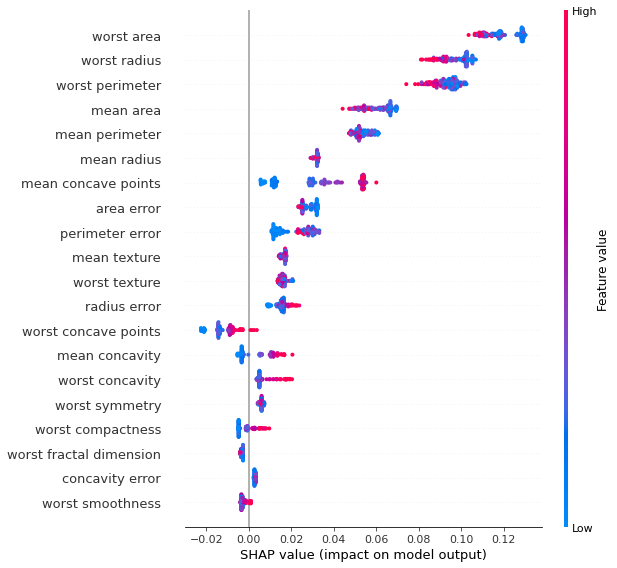

In [12]:
shap.summary_plot(shap_values[0], X_test)

Как его читать: 

- значения слева от центральной вертикальной линии — это negative класс (0) доброкачественная опухоль, справа — positive (1) злокачественная опухоль
- чем толще линия на графике, тем больше таких точек наблюдения
- чем краснее точка на графике, тем выше значения признака в ней

Из графика можно сделать интересные выводы и проверить их адекватность:
- первые 8 признаков связаны с доброкачественной опухолью
- worst concave points напрямую связано с злокачественной опухолью
- texture error высокие значения говорят о доброкачественной опухоли, а низкие о злокачественной

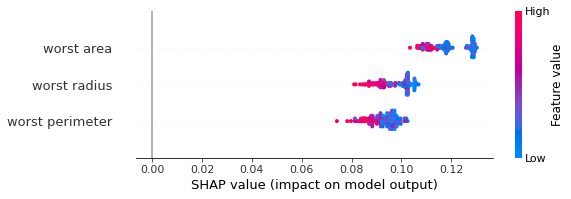

In [13]:
shap.summary_plot(shap_values[0], X_test,
                      max_display=int(X_test.shape[1]*0.1))

In [14]:
shap.force_plot(explainer.expected_value[0], shap_values[0], feature_names=cancer.feature_names)

In [15]:
# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value[0], shap_values[0][0], X_train.iloc[0,:])